In [1]:
!ls ../input/*

../input/item_categories.csv  ../input/sample_submission.csv
../input/items.csv	      ../input/shops.csv
../input/sales_train.csv      ../input/test.csv


In [2]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import pickle
from itertools import product
import gc
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.model_selection import KFold
from scipy.sparse import csr_matrix, hstack
from sklearn.decomposition import TruncatedSVD, NMF
from MulticoreTSNE import MulticoreTSNE as TSNE

In [3]:
SEED = 42
DATA_PATH = '../input/'
PROCESS_LAST_MONTHS = 24
SPANS = [1, 2, 3, 4, 12]
CAT_COLS = ['item_id', 'shop_id', 'item_category_id', 'city_id', 'type_id', 'subtype_id']
NUM_COMPONENTS = 5
CAT_COMPONENTS = 5

### Import data

In [4]:
# Load data
train = pd.read_csv(DATA_PATH             + "/sales_train.csv")
item_categories = pd.read_csv(DATA_PATH   + "/item_categories.csv")
items = pd.read_csv(DATA_PATH             + "/items.csv")
shops = pd.read_csv(DATA_PATH             + "/shops.csv")
sample_submission = pd.read_csv(DATA_PATH + "/sample_submission.csv")
test = pd.read_csv(DATA_PATH              + "/test.csv")

print(train.shape, test.shape)

(2935849, 6) (214200, 3)


In [5]:
train = train[train.date_block_num>train.date_block_num.max()-PROCESS_LAST_MONTHS]

print(train.date_block_num.nunique())

24


In [6]:
# The test data before and after transformations will remain the same order
test.drop('ID', axis=1, inplace=True)

In [7]:
# Replace negative prices with medians
invalid_idxs = train[train.item_price < 0].index
print(invalid_idxs)

for idx in invalid_idxs:
    date_block_num, shop_id, item_id = train.loc[idx, ['date_block_num', 'shop_id', 'item_id']]
    train.loc[idx, 'item_price'] = \
        train.loc[(train['date_block_num']==date_block_num) 
                  & (train['shop_id']==shop_id) 
                  & (train['item_id']==item_id) 
                  & (train['item_price']>0), 'item_price'].median()

Int64Index([], dtype='int64')


### Monthly sales

In [8]:
# Sum up the number of items sold/returned in each month and shop
train = train.groupby(['date_block_num','shop_id','item_id']).agg({'item_cnt_day': 'sum', 'item_price': 'mean'}).reset_index()
train.rename({'item_cnt_day': 'item_cnt_month'}, axis=1, inplace=True)

print(train.shape)

(1039136, 5)


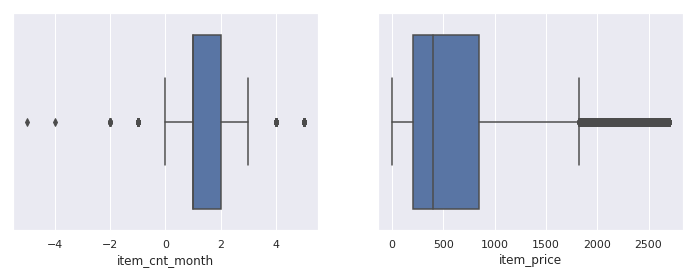

In [9]:
def quantile_cut(sr, lowerq, upperq):
    return sr[(sr > sr.quantile(lowerq)) & (sr < sr.quantile(upperq))]

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
sns.boxplot(quantile_cut(train.item_cnt_month, 0, 0.95), ax=ax[0]);
sns.boxplot(quantile_cut(train.item_price, 0, 0.95), ax=ax[1]);

### Align train and test

In [10]:
# How columns of both sets differ
print(set(train.columns).difference(set(test.columns)))
print(set(test.columns).difference(set(train.columns)))

{'date_block_num', 'item_cnt_month', 'item_price'}
set()


In [11]:
# Test set comes from Nov 2015
test['date_block_num'] = train.date_block_num.max() + 1

In [12]:
print("Both sets")
train_pairs = set(zip(train.shop_id, train.item_id))
test_pairs = set(zip(test.shop_id, test.item_id))
shop_item_pairs = train_pairs | test_pairs
print('\tshop-item pairs  ', len(shop_item_pairs))

print("Missing in train")
print('\tshop ids         ', test.shop_id[~test.shop_id.isin(train.shop_id)].nunique())
print('\titem ids         ', test.item_id[~test.item_id.isin(train.item_id)].nunique())
print('\tshop-item pairs  ', len(test_pairs.difference(train_pairs)))

print("Missing in test")
print('\tshop ids         ', train.shop_id[~train.shop_id.isin(test.shop_id)].nunique())
print('\titem ids         ', train.item_id[~train.item_id.isin(test.item_id)].nunique())
print('\tshop-item pairs  ', len(train_pairs.difference(test_pairs)))

Both sets
	shop-item pairs   403420
Missing in train
	shop ids          0
	item ids          370
	shop-item pairs   106715
Missing in test
	shop ids          13
	item ids          13378
	shop-item pairs   189220


In [13]:
# Fraction of shop/item pairs out of all possible pairs in the test set
len(list(product(test.shop_id.unique(), test.item_id.unique()))) / len(test)

1.0

In [14]:
# Product of all possible shop/item pairs for each month to make train and test similar
id_products = []
cols = ['date_block_num', 'shop_id', 'item_id']
for date_block_num in train.date_block_num.unique():
    df = train[train.date_block_num==date_block_num]
    group = np.array(list(product([date_block_num], 
                                  df.shop_id.unique(), 
                                  df.item_id.unique())))
    id_products.append(group)
id_products = np.vstack(id_products)
id_products = pd.DataFrame(id_products, columns=cols)

print(id_products.shape)

(7178903, 3)


In [15]:
train = pd.merge(id_products, train, how='left', on=cols)
# Leaving upper bound open may be beneficial for learning
train['item_cnt_month'] = train['item_cnt_month'].fillna(0).clip(0, 20)

print(train.shape)

(7178903, 5)


In [16]:
# Ensure we have done everything correctly
for num in train.date_block_num.unique():
    df = train[train.date_block_num == num]
    assert(len(list(product(df.shop_id.unique(), df.item_id.unique()))) / len(df) == 1.0)

In [17]:
# Append test to train to make feature engineering easier
traintest = train.append(test, ignore_index=True)

# Record index of the train part of the concatenated set
is_train = traintest.date_block_num < 34

print(traintest.shape)

(7393103, 5)


In [18]:
del train
del test

### Text features

In [19]:
# Fix duplicate shop names
# !Якутск Орджоникидзе, 56 фран == Якутск Орджоникидзе, 56
traintest.loc[traintest.shop_id == 0, 'shop_id'] = 57
# !Якутск ТЦ "Центральный" фран == Якутск ТЦ "Центральный"
traintest.loc[traintest.shop_id == 1, 'shop_id'] = 58
# Жуковский ул. Чкалова 39м? == Жуковский ул. Чкалова 39м²
traintest.loc[traintest.shop_id == 10, 'shop_id'] = 11

In [20]:
# Extract cities
assert((shops.groupby('shop_id')['shop_name'].nunique()==1).all())
assert((shops.groupby('shop_name')['shop_id'].nunique()==1).all())

shops.loc[shops.shop_name == 'Интернет-магазин ЧС', 'shop_name'] = 'Интернет-магазин ЧС'
shops.loc[shops.shop_name == 'Цифровой склад 1С-Онлайн', 'shop_name'] = 'Интернет-магазин 1С-Онлайн'
shops.loc[shops.shop_name == 'Сергиев Посад ТЦ "7Я"', 'shop_name'] = 'СергиевПосад ТЦ "7Я"'
shops.loc[shops.shop_name == '!Якутск Орджоникидзе, 56 фран', 'shop_name'] = 'Якутск Орджоникидзе, 56 фран'
shops.loc[shops.shop_name == '!Якутск ТЦ "Центральный" фран', 'shop_name'] = 'Якутск ТЦ "Центральный" фран'
shops['city_name'] = shops['shop_name'].str.split(' ').map(lambda x: x[0])
shops['city_id'] = LabelEncoder().fit_transform(shops['city_name'])
shops = shops[['shop_id', 'city_id']]

print(shops.nunique())

shop_id    60
city_id    30
dtype: int64


In [21]:
# Extract item category types and subtypes
assert((item_categories.groupby('item_category_id')['item_category_name'].nunique()==1).all())
assert((item_categories.groupby('item_category_name')['item_category_id'].nunique()==1).all())

item_categories['type'] = item_categories['item_category_name'].str.split('-').map(
    lambda x: x[0].strip())
item_categories['type_id'] = LabelEncoder().fit_transform(item_categories['type'])
item_categories['subtype'] = item_categories['item_category_name'].str.split('-').map(
    lambda x: x[1].strip() if len(x) > 1 else x[0].strip())
item_categories['subtype_id'] = LabelEncoder().fit_transform(item_categories['subtype'])
item_categories = item_categories[['item_category_id', 'type_id', 'subtype_id']]

print(item_categories.nunique())

item_category_id    84
type_id             20
subtype_id          65
dtype: int64


In [22]:
items = items[['item_id', 'item_category_id']]

print(items.nunique())

item_id             22170
item_category_id       84
dtype: int64


In [23]:
# Join with newly extracted features
traintest = (traintest.join(items, on='item_id', rsuffix='_other').drop('item_id_other', axis=1)
             .join(item_categories, on='item_category_id', rsuffix='_other').drop('item_category_id_other', axis=1)
             .join(shops, on='shop_id', rsuffix='_other').drop('shop_id_other', axis=1))

print(traintest.shape)

(7393103, 9)


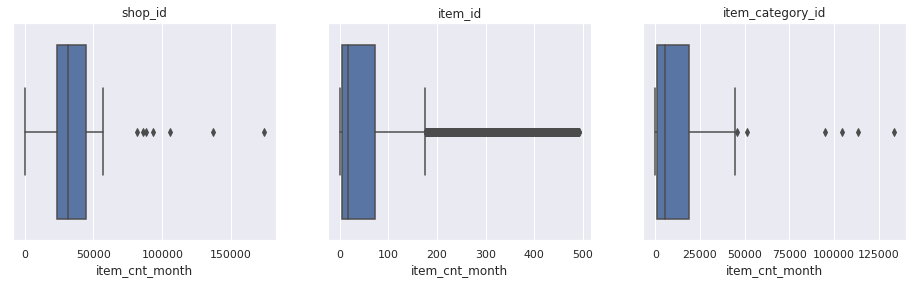

In [24]:
fig, ax = plt.subplots(1, 3, figsize=(16, 4))
sns.boxplot(traintest[is_train].groupby('shop_id')['item_cnt_month'].sum(), ax=ax[0])
ax[0].set_title('shop_id')
sns.boxplot(quantile_cut(traintest[is_train].groupby('item_id')['item_cnt_month'].sum(), 0, 0.95), ax=ax[1])
ax[1].set_title('item_id')
sns.boxplot(quantile_cut(traintest[is_train].groupby('item_category_id')['item_cnt_month'].sum(), 0, 0.95), ax=ax[2])
ax[2].set_title('item_category_id')
plt.show()

In [25]:
del item_categories
del items
del shops

### Date features

In [26]:
# Extract year and month from each date block
traintest['month'] = traintest.date_block_num % 12 + 1

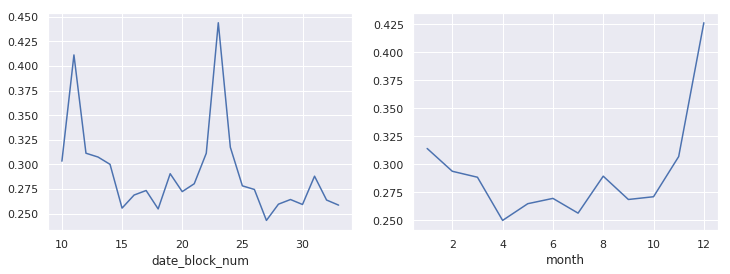

In [27]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
traintest[is_train].groupby('date_block_num')['item_cnt_month'].mean().plot(ax=ax[0])
traintest[is_train].groupby('month')['item_cnt_month'].mean().plot(ax=ax[1])
plt.show()

### Lagged features

In [28]:
def downcast_sr(sr):
    sr = sr.fillna(0)
    # Downcast that resulting data to the smallest numerical dtype possible
    if 'float' in str(sr.dtype):
        return pd.to_numeric(sr, downcast='float')
    elif 'int' in str(sr.dtype):
        return pd.to_numeric(sr, downcast='unsigned')
    else:
        return sr
            
def downcast(traintest):
    # Reduce memory footprint
    for col in traintest.columns:
        traintest[col] = downcast_sr(traintest[col])

In [29]:
downcast(traintest)

In [30]:
def lagged_features(traintest, col, spans=SPANS):
    tmp = traintest[['date_block_num', 'shop_id', 'item_id', col]]
    for span in spans:
        shifted = tmp.copy()
        new_col_name = col+'_lag_'+str(span)
        shifted.columns = ['date_block_num', 'shop_id', 'item_id', new_col_name]
        shifted['date_block_num'] += span
        traintest = pd.merge(traintest, shifted, on=['date_block_num', 'shop_id', 'item_id'], how='left')
        # Downcast inplace to safe memory
        traintest[new_col_name] = downcast_sr(traintest[new_col_name])
    return traintest

In [31]:
%%time
# Lagged monthly sales/revenue per shop and item
traintest = lagged_features(traintest, 'item_cnt_month')
traintest = lagged_features(traintest, 'item_price')

traintest.drop(['item_price'], axis=1, inplace=True)

CPU times: user 48.4 s, sys: 14.1 s, total: 1min 2s
Wall time: 1min 2s


### Target encoding

In [32]:
def kfold_target_enc(train, col, n_splits=5):
    # K-fold regularisation for mean encodings
    # 1. Split train data into k folds
    # 2. Exclude the fold that contains a sample
    # 3. Estimate encoding for the sample with the data that left
    
    globalmean = train['item_cnt_month'].mean()
    kf = KFold(n_splits=n_splits, shuffle=False, random_state=SEED)
    encoded = pd.Series(index=train.index)
    
    for train_idx, valid_idx in kf.split(train):
        X_train, X_valid = train.iloc[train_idx], train.iloc[valid_idx]
        means = X_valid[col].map(X_train.groupby(col)['item_cnt_month'].mean())
        encoded.iloc[valid_idx] = means
        
    encoded = encoded.fillna(globalmean)
    return encoded

In [33]:
def expanding_target_enc(train, col):
    # Expanding mean regularization:
    # 1. Fix some random permutation of rows (samples)
    # 2. Moving from top to bottom, for each example, estimate the encoding using target mean 
    # of all the examples before the estimated one. An estimated example is not used.
    
    globalmean = train['item_cnt_month'].mean()
    cumsum = train.groupby(col).item_cnt_month.cumsum() - train.item_cnt_month
    sumcnt = train.groupby(col).cumcount()
    expanding_mean = cumsum / sumcnt
    expanding_mean = expanding_mean.fillna(globalmean)
    return expanding_mean

In [34]:
def loo_target_enc(train, col, alpha=100):
    # LOO with date blocks leads to overfitting but at least visible locally
    # Use smoothing to trust larger categories and decrease the leakage
    
    globalmean = train['item_cnt_month'].mean()
    encoded = pd.Series(index=train.index)
    
    for date_block_num in train.date_block_num.unique():
        X_train = train[train.date_block_num != date_block_num]
        X_valid = train[train.date_block_num == date_block_num]
        means = X_train.groupby(col).item_cnt_month.agg('mean')
        nrows = X_train.groupby(col).size()
        smoothed_means = (np.multiply(means, nrows) + globalmean * alpha) / (nrows + alpha)
        smoothed_means = X_valid[col].map(smoothed_means)
        encoded.loc[X_valid.index] = smoothed_means
        
    encoded = encoded.fillna(globalmean)
    return encoded

In [35]:
def print_te_corrcoef(train, col, last_months=6):
    for fn in [kfold_target_enc, 
               expanding_target_enc, 
               loo_target_enc]:
        # Limit time window for faster processing
        df = train[train.date_block_num>train.date_block_num.max()-last_months]
        target = df.item_cnt_month
        corrcoef = np.corrcoef(fn(df, col), target)[0][1]
        print("\t{:<25}{:.4f}".format(fn.__name__, corrcoef))

In [36]:
# https://www.coursera.org/learn/competitive-data-science/lecture/LGYQ2/regularization
for col in CAT_COLS:
    print(col)
    print_te_corrcoef(traintest[is_train], col)
    gc.collect()

item_id
	kfold_target_enc         0.4932
	expanding_target_enc     0.5768
	loo_target_enc           0.4891
shop_id
	kfold_target_enc         0.1686
	expanding_target_enc     0.2008
	loo_target_enc           0.1697
item_category_id
	kfold_target_enc         0.3311
	expanding_target_enc     0.3321
	loo_target_enc           0.3254
city_id
	kfold_target_enc         0.1213
	expanding_target_enc     0.1316
	loo_target_enc           0.1218
type_id
	kfold_target_enc         0.1515
	expanding_target_enc     0.1542
	loo_target_enc           0.1515
subtype_id
	kfold_target_enc         0.3295
	expanding_target_enc     0.3305
	loo_target_enc           0.3237


In [37]:
def lagged_target_enc(traintest, cols):
    # Method which rarely leads to overfitting
    new_col_name = '_'.join(cols) + '_mean'
    groupby = ['date_block_num'] + cols
    group = traintest[is_train].groupby(groupby)['item_cnt_month'].apply(np.mean)
    group = group.reset_index()
    group = group.rename({'item_cnt_month': new_col_name}, axis=1)
    traintest = pd.merge(traintest, group, on=groupby, how='left')
    traintest = lagged_features(traintest, new_col_name)
    traintest.drop(new_col_name, axis=1, inplace=True)
    return traintest

In [38]:
%%time
# Using of these mean encodings leads to overfitting so lagged features are safer
for col in CAT_COLS:
    traintest = lagged_target_enc(traintest, [col])
    gc.collect()
traintest = lagged_target_enc(traintest, ['shop_id', 'item_category_id'])
traintest = lagged_target_enc(traintest, ['shop_id', 'type_id'])
traintest = lagged_target_enc(traintest, ['shop_id', 'subtype_id'])

CPU times: user 5min 32s, sys: 2min 31s, total: 8min 3s
Wall time: 8min 3s


### Matrix decomposition

In [39]:
def decompose_numeric_features(traintest):
    # Generate new features with dimensionality reduction
    cols = traintest.columns.difference(CAT_COLS)
    features = traintest[cols].drop('item_cnt_month', axis=1).values
    features = StandardScaler().fit_transform(features)
    # Reduce dimensionality using SVD which is best for sparse matrices as compared to PCA
    pca_features = TruncatedSVD(n_components=NUM_COMPONENTS, random_state=SEED).fit_transform(features)
    pca_features = pd.DataFrame(pca_features, columns=['num_pca_%d'%i for i in range(pca_features.shape[1])])
    downcast(pca_features)
    traintest = pd.merge(traintest, pca_features, left_index=True, right_index=True)
    return traintest

In [40]:
%%time
traintest = decompose_numeric_features(traintest)

print(traintest.shape)

(7393103, 69)
CPU times: user 58 s, sys: 18.9 s, total: 1min 16s
Wall time: 52.5 s


In [41]:
def decompose_categorical_features(traintest):
    # Embedding of the categories in a low-dimensional numeric space
    # First, transform categorical features into one-hot-encoded features
    ohe_features = OneHotEncoder().fit_transform(traintest[CAT_COLS])
    # NMF transforms data in a way that makes data more suitable for decision trees
    # from n_components=10 very slow
    pca_features = NMF(n_components=CAT_COMPONENTS, random_state=SEED).fit_transform(ohe_features)
    pca_features = pd.DataFrame(pca_features, columns=['cat_pca_%d'%i for i in range(pca_features.shape[1])])
    downcast(pca_features)
    traintest = pd.merge(traintest, pca_features, left_index=True, right_index=True)
    return traintest

In [42]:
%%time
# Mean encoding doesn't work as expected, so encode categorical features with matrix factorization
traintest = decompose_categorical_features(traintest)

print(traintest.shape)

(7393103, 74)
CPU times: user 2min 8s, sys: 42.6 s, total: 2min 50s
Wall time: 2min 42s


In [43]:
num_cols = traintest.columns.difference(CAT_COLS)

traintest.loc[is_train, num_cols].corrwith(traintest.loc[is_train, 'item_cnt_month']).sort_values(ascending=False).iloc[:20]

item_cnt_month                         1.000000
item_cnt_month_lag_1                   0.562875
item_id_mean_lag_1                     0.468201
item_cnt_month_lag_2                   0.417869
shop_id_item_category_id_mean_lag_1    0.399798
shop_id_subtype_id_mean_lag_1          0.396591
item_cnt_month_lag_3                   0.346510
num_pca_0                              0.344506
item_id_mean_lag_2                     0.340545
shop_id_item_category_id_mean_lag_2    0.335555
shop_id_subtype_id_mean_lag_2          0.332728
shop_id_item_category_id_mean_lag_3    0.300300
item_category_id_mean_lag_1            0.297430
shop_id_subtype_id_mean_lag_3          0.296740
subtype_id_mean_lag_1                  0.294485
item_cnt_month_lag_4                   0.293350
item_id_mean_lag_3                     0.281390
shop_id_type_id_mean_lag_1             0.270261
shop_id_item_category_id_mean_lag_4    0.267449
shop_id_subtype_id_mean_lag_4          0.264762
dtype: float64

### Save data

In [44]:
traintest.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7393103 entries, 0 to 7393102
Data columns (total 74 columns):
date_block_num                          uint8
item_cnt_month                          float32
item_id                                 uint16
shop_id                                 uint8
item_category_id                        uint8
type_id                                 uint8
subtype_id                              uint8
city_id                                 uint8
month                                   uint8
item_cnt_month_lag_1                    float32
item_cnt_month_lag_2                    float32
item_cnt_month_lag_3                    float32
item_cnt_month_lag_4                    float32
item_cnt_month_lag_12                   float32
item_price_lag_1                        float32
item_price_lag_2                        float32
item_price_lag_3                        float32
item_price_lag_4                        float32
item_price_lag_12                     

In [45]:
%%time
traintest.to_hdf('data.h5', key='traintest', mode='w', format='table')

CPU times: user 13.5 s, sys: 2.7 s, total: 16.2 s
Wall time: 20.7 s


### Mean benchmark

In [46]:
def submit(y_pred, fname='submission.csv'):
    submission = pd.DataFrame({
        "ID": range(len(y_pred)), 
        "item_cnt_month": y_pred
    })
    submission['item_cnt_month'] = submission.item_cnt_month.fillna(0).clip(0, 20)
    submission.to_csv(fname, index=False)
    print(submission.head())

In [47]:
# Best single-value benchmark for RMSE
target = pd.Series(traintest.loc[is_train, 'item_cnt_month'].mean(), 
                   index=traintest.loc[~is_train].reset_index().index)
submit(target, fname='mean_benchmark.csv')

   ID  item_cnt_month
0   0        0.295224
1   1        0.295224
2   2        0.295224
3   3        0.295224
4   4        0.295224


### Previous month benchmark

In [48]:
def prev_month_benchmark(date_block_num):
    merge_on = ['shop_id', 'item_id']
    last_month_data = traintest.loc[traintest.date_block_num==date_block_num-1, merge_on+['item_cnt_month']]
    this_month_data = traintest.loc[traintest.date_block_num==date_block_num, merge_on]
    merged = this_month_data.merge(last_month_data, how='left', on=merge_on)
    return merged.item_cnt_month

In [49]:
submit(prev_month_benchmark(34), fname='prev_month_benchmark.csv')

   ID  item_cnt_month
0   0             0.0
1   1             0.0
2   2             1.0
3   3             0.0
4   4             0.0
